#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 36.7 MB/s 
     |████████████████████████████████| 125 kB 69.1 MB/s 
     |████████████████████████████████| 512 kB 67.4 MB/s 


Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 18 18:22 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [4]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torchvision.models import resnet18, resnet34
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

In [5]:
import pprint
with open('data/train/apple_11.xml') as f:
    dct = xmltodict.parse(f.read())
pprint.PrettyPrinter().pprint(dct)

{'annotation': {'filename': 'apple_11.jpg',
                'folder': 'train',
                'object': [{'bndbox': {'xmax': '459',
                                       'xmin': '213',
                                       'ymax': '258',
                                       'ymin': '33'},
                            'difficult': '0',
                            'name': 'apple',
                            'pose': 'Unspecified',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '188',
                                       'xmin': '1',
                                       'ymax': '280',
                                       'ymin': '30'},
                            'difficult': '0',
                            'name': 'apple',
                            'pose': 'Unspecified',
                            'truncated': '1'},
                           {'bndbox': {'xmax': '337',
                                       'xmin': '116',
     

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [6]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, S=7, B=2, C=3):
        self.image_paths = sorted(glob.glob(data_dir + '/**.jpg'))
        self.box_paths = sorted(glob.glob(data_dir + '/**.xml'))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms
        self.S = S
        self.B = B
        self.C = C

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])


        if self.transforms is not None:
            dct = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = dct['image']
            boxes = dct['bboxes']
            class_labels = dct['class_labels']

        new_target = torch.zeros(self.S*self.S*(5*self.B + self.C)).view(self.S*self.S, 5*self.B + self.C)
        delta_x = WIDTH // self.S
        delta_y = HEIGHT // self.S
        for box, label in zip(boxes, class_labels):
            i = int((box[0] * WIDTH // delta_x) + (box[1] * HEIGHT // delta_y) * self.S)
            new_target_label = new_target[i][-self.C:]
            new_target_boxes = new_target[i][:-self.C].view(self.B, 5)

            new_target_boxes[0][:-1] = torch.tensor(box)
            new_target_boxes[0][-1] = 1
            new_target_label[label - 1] = 1

        return image, new_target

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []
        with open(xml_filename) as f:
            dct = xmltodict.parse(f.read())['annotation']

        objects = dct['object']
        image = np.array(Image.open(xml_filename[:-3] + 'jpg').convert("RGB"))
        img_w = image.shape[1]
        img_h = image.shape[0]
        if isinstance(objects, dict):
            class_labels.append(class2tag[objects['name']])
            boxes.append(self.__convert_to_yolo_box_params(list(map(int, objects['bndbox'].values())), img_w, img_h))
        else:
            for obj in objects:
              class_labels.append(class2tag[obj['name']])
              boxes.append(self.__convert_to_yolo_box_params(list(map(int, obj['bndbox'].values())), img_w, img_h))

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []

      ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
      ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [7]:
from torchvision.transforms import ToTensor
mean = torch.tensor([0., 0., 0.])
std = torch.tensor([0., 0., 0.])
count = 0
for img_path in glob.glob('data/train/**.jpg'):
    img = ToTensor()(Image.open(img_path).convert('RGB'))
    mean += img.mean([1, 2])
    std += img.std([1, 2])
    count += 1
mean /= count
std /= count

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
from torchvision.transforms import RandomApply
WIDTH = HEIGHT = 448

train_transform = A.Compose([A.Resize(HEIGHT, WIDTH), A.Normalize(mean, std), A.Compose([A.RandomRotate90(p=0.2), A.RandomFog(p=0.2), A.RGBShift(p=0.2), A.ToGray(p=0.2)], p=0.5),  A.pytorch.transforms.ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(HEIGHT, WIDTH), A.Normalize(mean, std), A.pytorch.transforms.ToTensorV2()],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [27]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [28]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [29]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: dt_bbox - [x_max, y_max, x_min, y_min]
    :param: gt_bbox - [x_max, y_max, x_min, y_min]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

In [116]:
from torch.nn.modules import padding
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)
        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        # self.net = []
        # in_channels = [3, 192, 256, 128, 256, 512, 1024, 512, 1024]
        # out_channels = [192, 256, 128, 256, 512, 1024, 512, 1024, 1024]
        # maxpool_params = [True, True, False, True, False, True, False, False, False]
        # kwargs = [{'kernel_size': 7, 'stride': 2, 'padding': 3},
        #           {'kernel_size': 3, 'stride': 1, 'padding': 1},
        #           {'kernel_size': 1, 'stride': 1, 'padding': 0},
        #           {'kernel_size': 3, 'stride': 1, 'padding': 1},
        #           {'kernel_size': 3, 'stride': 1, 'padding': 1},
        #           {'kernel_size': 3, 'stride': 1, 'padding': 1},
        #           {'kernel_size': 1, 'stride': 1, 'padding': 0},
        #           {'kernel_size': 3, 'stride': 2, 'padding': 1},
        #           {'kernel_size': 3, 'stride': 1, 'padding': 1}]
        # for input, output, is_pool, kwarg in zip(in_channels, out_channels, maxpool_params, kwargs):
        #     self.net.append(CNNBlock(in_channels=input,
        #                              out_channels=output,
        #                              is_max_pool=is_pool,
        #                              kernel_size=kwarg['kernel_size'],
        #                              stride=kwarg['stride'],
        #                              padding=kwarg['padding'],
        #                              padding_mode='replicate'))
        # self.head = nn.Sequential(
        #     nn.Linear(7*7*1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, self.S*self.S*(5*self.B + self.C))
        # )
        self.net = resnet34(pretrained=True)
        for param in self.net.parameters():
            param.requires_grad = False
        self.net.fc = nn.Linear(512, 4096, bias=True)
        self.head = nn.Linear(4096, self.S*self.S*(5*self.B + self.C))

    def forward(self, x, targets=None):
        # for block in self.net:
        #     x = block(x)
        x = self.net(x)
        return self.head(nn.ReLU()(x)).view((-1, self.S * self.S, 5*self.B + self.C))


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (temp_model.B * 5 + temp_model.C)

assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Реализуйте YoloLoss - 3 балла

In [31]:
def convert_to_our_box_params(box_coordinates):
        x, y, w, h = box_coordinates
        x *= WIDTH
        y *= HEIGHT
        w *= WIDTH
        h *= HEIGHT
        return torch.Tensor([x - int(w) // 2,
                             y -  int(h) // 2,
                             x + int(w) // 2,
                             y +  int(h) // 2])

In [33]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions1 = torch.clone(predictions)
        for batch in range(len(predictions)):
            obj_i = set()
            for i in range(self.S * self.S):
                if target[batch][i][4] == 1:
                    obj_i.add(i)
                    preds_label = predictions[batch][i][-self.C:]
                    preds_boxes = predictions[batch][i][:-self.C].view(self.B, 5)
                    preds_label1 = predictions1[batch][i][-self.C:]
                    preds_boxes1 = predictions1[batch][i][:-self.C].view(self.B, 5)

                    target[batch][i][:5] = target[batch][i][:5] * (self.lambda_coord**0.5)

                    max_IoU = -1
                    resp_box = -1
                    for j in range(self.B):
                        IoU = intersection_over_union(convert_to_our_box_params(preds_boxes[j, :-1].tolist()),
                                                      convert_to_our_box_params(target[batch][i][:4].tolist()))
                        if max_IoU == -1 or IoU > max_IoU:
                            max_IoU = IoU
                            resp_box = j

                    for j in range(self.B):
                        if j == resp_box:
                            preds_boxes1[j][2] = abs(preds_boxes[j][2])**0.5 * torch.sign(preds_boxes[j][2])
                            preds_boxes1[j][3] = abs(preds_boxes[j][3])**0.5 * torch.sign(preds_boxes[j][3])
                            preds_boxes1[j][:-1] = preds_boxes[j][:-1] * (self.lambda_coord**0.5)
                        else:
                            preds_boxes1[j][:-1] = preds_boxes[j][:-1] * 0
                            preds_boxes1[j][-1]  = preds_boxes[j][-1] * (self.lambda_noobj**0.5)


                    preds_boxes1[0], preds_boxes1[resp_box] = preds_boxes1[resp_box], preds_boxes1[0]
        
            for j in range(self.S * self.S):
                if j not in obj_i:
                    predictions1[batch][j][4::5] = predictions[batch][j][4::5] * (self.lambda_noobj**0.5)
                    for i in range(self.B * 5):
                        if (i + 1) % 5 != 0:
                            predictions1[batch][j][i] = predictions[batch][j][i] * 0
        return self.mse(predictions1.view(-1), target.view(-1))

## Реализуйте дополнительные функции из статьи - 2 балла

In [36]:
def non_max_suppression(bboxes, iou_threshold, threshold, S=7, B=2, C=3):
    boxes = bboxes[:, :-C].reshape(-1, 5)
    labels = bboxes[:, -C:]
    mask = []
    for i in range(len(labels)):
        mask.append(i)
        mask.append(i)
    labels = labels[mask]
    boxes = torch.cat([boxes, labels], dim=1).tolist()
    best_boxes = []
    for i in range(len(boxes)):
        if boxes[i][4] > threshold:
            best_boxes.append(boxes[i])
    best_boxes = sorted(best_boxes, key=lambda x: x[4])
    ans = []
    while len(best_boxes) != 0:
        ans.append(best_boxes.pop())
        for i in range(len(best_boxes) - 1, -1, -1):
            if intersection_over_union(convert_to_our_box_params(ans[-1][:4]), convert_to_our_box_params(best_boxes[i][:4])) > iou_threshold:
                best_boxes.pop(i)
    return ans
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    ## YOUR CODE
    pass

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_boxes = []
    all_true_boxes = []
    imgs = []
    for images, targets in tqdm.tqdm(loader):
        preds = model(images)
        imgs.append(images)
        for j in range(len(images)):
            all_true_boxes.append(targets[j][targets[j][..., 4] == 1][:, [0, 1, 2, 3, -3, -2, -1]].tolist())
            all_pred_boxes.append(non_max_suppression(preds[j],
                                                      iou_threshold=iou_threshold,
                                                      threshold=threshold))
    return all_pred_boxes, all_true_boxes, torch.cat(imgs)

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [117]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()

        self.model = model
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch: 0.9**epoch)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler]

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, targets = train_batch
        preds = self.model(images)
        loss = self.loss(preds, targets)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, targets = val_batch
        preds = self.model(images)
        loss = self.loss(preds, targets)
        self.log('val_loss', loss, prog_bar=True)

In [118]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = YOLO().to(device)
# for el in model.net:
#     el.to(device)
#model.head.to(device)
n_epochs = 15
yolo_learner = YOLOLearner(model)

trainer = pl.Trainer(accelerator='gpu', max_epochs=n_epochs)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 26.0 M
1 | loss  | YoloLoss | 0     
-----------------------------------
4.7 M     Trainable params
21.3 M    Non-trainable params
26.0 M    Total params
103.983   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [119]:
yolo_learner.optimizer = torch.optim.Adam(yolo_learner.model.parameters(), lr=1e-4)
yolo_learner.scheduler = torch.optim.lr_scheduler.LambdaLR(yolo_learner.optimizer, lr_lambda=lambda epoch: 0.95**epoch)
trainer = pl.Trainer(accelerator='gpu', max_epochs=n_epochs)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 26.0 M
1 | loss  | YoloLoss | 0     
-----------------------------------
4.7 M     Trainable params
21.3 M    Non-trainable params
26.0 M    Total params
103.983   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [120]:
yolo_learner.optimizer = torch.optim.Adam(yolo_learner.model.parameters(), lr=1e-6)
yolo_learner.scheduler = torch.optim.lr_scheduler.LambdaLR(yolo_learner.optimizer, lr_lambda=lambda epoch: 0.9**epoch)
trainer = pl.Trainer(accelerator='gpu', max_epochs=n_epochs)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 26.0 M
1 | loss  | YoloLoss | 0     
-----------------------------------
4.7 M     Trainable params
21.3 M    Non-trainable params
26.0 M    Total params
103.983   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [23]:
## YOUR CODE net

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [121]:
model = model.to('cpu')
# for el in model.net:
#     el.to('cpu')
# model.head.to('cpu')

In [122]:
all_pred_boxes, all_true_boxes, images = get_bound_boxes(val_dataloader, model, threshold=0.7)

100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


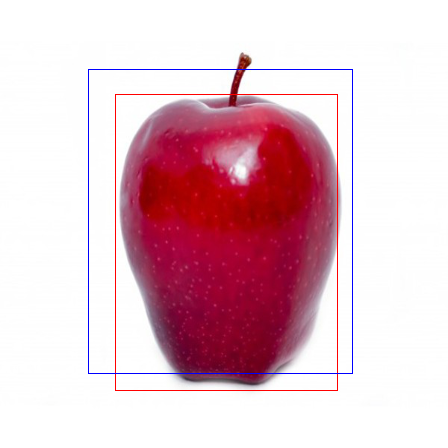

In [123]:
from PIL import ImageDraw

idx = 3
color_target = ['red', 'orange', 'yellow']  # красный для яблока, оранжевый для апельсина и жёлтый для банана
color_preds = ['blue', 'green', 'black']    # голубой для яблока, зелёный для апельсина и чёрный для банана

image = torchvision.transforms.ToPILImage()((images[idx].permute(1, 2, 0)*std + mean).permute(2, 0, 1))
draw = ImageDraw.Draw(image)

for b in all_true_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_target[np.argmax(b[-3:])])

for b in all_pred_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_preds[np.argmax(b[-3:])])
image

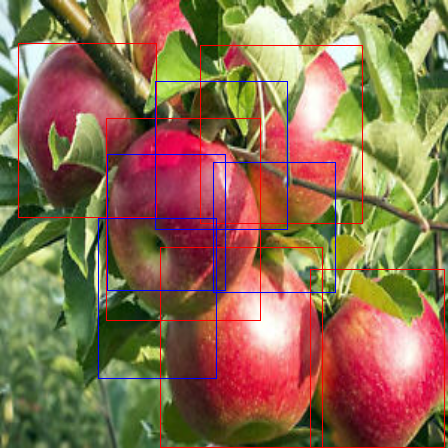

In [124]:
idx = 0
color_target = ['red', 'orange', 'yellow']  # красный для яблока, оранжевый для апельсина и жёлтый для банана
color_preds = ['blue', 'green', 'black']    # голубой для яблока, зелёный для апельсина и чёрный для банана

image = torchvision.transforms.ToPILImage()((images[idx].permute(1, 2, 0)*std + mean).permute(2, 0, 1))
draw = ImageDraw.Draw(image)

for b in all_true_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_target[np.argmax(b[-3:])])

for b in all_pred_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_preds[np.argmax(b[-3:])])
image

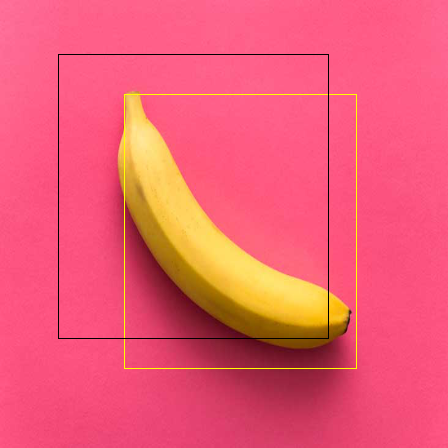

In [125]:
idx = 30
color_target = ['red', 'orange', 'yellow']  # красный для яблока, оранжевый для апельсина и жёлтый для банана
color_preds = ['blue', 'green', 'black']    # голубой для яблока, зелёный для апельсина и чёрный для банана

image = torchvision.transforms.ToPILImage()((images[idx].permute(1, 2, 0)*std + mean).permute(2, 0, 1))
draw = ImageDraw.Draw(image)

for b in all_true_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_target[np.argmax(b[-3:])])

for b in all_pred_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_preds[np.argmax(b[-3:])])
image

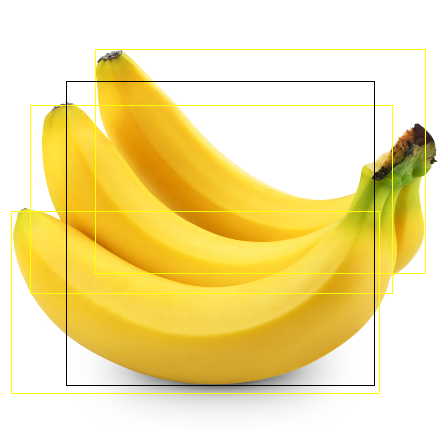

In [126]:
idx = 31
color_target = ['red', 'orange', 'yellow']  # красный для яблока, оранжевый для апельсина и жёлтый для банана
color_preds = ['blue', 'green', 'black']    # голубой для яблока, зелёный для апельсина и чёрный для банана

image = torchvision.transforms.ToPILImage()((images[idx].permute(1, 2, 0)*std + mean).permute(2, 0, 1))
draw = ImageDraw.Draw(image)

for b in all_true_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_target[np.argmax(b[-3:])])

for b in all_pred_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_preds[np.argmax(b[-3:])])
image

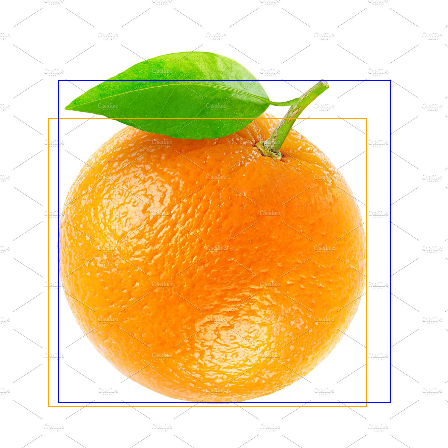

In [127]:
idx = 59
color_target = ['red', 'orange', 'yellow']  # красный для яблока, оранжевый для апельсина и жёлтый для банана
color_preds = ['blue', 'green', 'black']    # голубой для яблока, зелёный для апельсина и чёрный для банана

image = torchvision.transforms.ToPILImage()((images[idx].permute(1, 2, 0)*std + mean).permute(2, 0, 1))
draw = ImageDraw.Draw(image)

for b in all_true_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_target[np.argmax(b[-3:])])

for b in all_pred_boxes[idx]:
    box = convert_to_our_box_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color_preds[np.argmax(b[-3:])])
image